In [156]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import normalize
from sklearn.metrics import roc_auc_score, precision_recall_curve, auc

In [157]:
ALPHA = 0.1
BETA = 0.1
DELTA_MAX = 0.015

In [158]:
import pandas as pd
import glob
import os

# Directory path
csv_dir = (
    "/scratch/project/tcr_ml/gnn_release/icantcrscoring/model_2025_sc_curated/theragen"
)

# Get all CSV files in the directory
csv_files = [
    f
    for f in glob.glob(os.path.join(csv_dir, "*.csv"))
    if os.path.basename(f) != "summary.csv"
]
# Load all CSV files into a list of DataFrames
dataframes = []
for file in csv_files:
    df = pd.read_csv(file)
    # Optional: add a column to track which file the data came from
    df["source_file"] = os.path.basename(file)
    dataframes.append(df)

# If you want to combine all DataFrames into one
combined_df = pd.concat(dataframes, ignore_index=True)

combined_df

,AA_seq,CloneFreq,prob,high,transformed_score,source_file
0,CASSLSPGTSGYEQYF,0.041550,0.000413,False,1.715318e-05,Sample_3_merged.csv
1,CASSLSPGTSGYEQYF,0.041550,0.403328,False,1.675822e-02,Sample_3_merged.csv
2,CASSLSPGTSGYEQYF,0.041550,1.000000,True,4.154983e-02,Sample_3_merged.csv
3,CASSLSPGTSGYEQYF,0.041550,0.043260,False,1.797426e-03,Sample_3_merged.csv
4,CASSLSPGTSGYEQYF,0.041550,0.007368,False,3.061503e-04,Sample_3_merged.csv
...,...,...,...,...,...,...
94343,CVSSSSTGYDEQYF,0.000002,0.283345,False,4.565375e-07,Sample_5_merged.csv
94344,CXSSYLAGAFTDTQYF,0.000002,0.284545,False,4.584705e-07,Sample_5_merged.csv
94345,CXXXYSNLMEGEQYF,0.000002,0.261190,False,4.208391e-07,Sample_5_merged.csv
94346,CYSSLGSLRVAYNEQFF,0.000002,0.002943,False,4.741676e-09,Sample_5_merged.csv


In [159]:
import numpy as np

# ----------------------------- Utilities -------------------------------- #


def _apply_open_interval(arr, open_interval: bool, eps: float):
    if not open_interval:
        return arr
    out = arr.copy()
    out[out <= 0.0] = eps
    out[out >= 1.0] = 1.0 - eps
    return out


def _plotting_position(ranks, m, method: str):
    if method == "weibull":
        return ranks / (m + 1.0)
    if method == "hazen":
        return (ranks - 0.5) / m
    if method == "blom":
        return (ranks - 0.375) / (m + 0.25)
    if method == "bernard":
        return (ranks - 3.0 / 8.0) / (m + 0.25)
    if method == "rank":
        return np.full(m, 0.5) if m == 1 else (ranks - 1.0) / (m - 1.0)
    raise ValueError(f"Unknown method '{method}'")


def _midranks_for_ties(sorted_vals_len: int, diffs: np.ndarray):
    # diffs is np.diff of sorted values
    # build tie groups, assign midranks in 1..m
    m = sorted_vals_len
    if m == 0:
        return np.empty(0, dtype=float)
    boundaries = np.flatnonzero(diffs != 0.0)
    starts = np.r_[0, boundaries + 1]
    stops = np.r_[boundaries, m - 1]
    ranks = np.empty(m, dtype=float)
    for s, e in zip(starts, stops):
        mid = (s + e) / 2.0
        ranks[s : e + 1] = mid + 1.0
    return ranks


# ----------------------------- Main API ---------------------------------- #


def fraction_to_percentile(
    x,
    weights=None,
    method="hazen",  # "weibull", "hazen", "blom", "bernard", "rank"
    open_interval=False,  # map [0,1] to (eps,1-eps) if True
    eps=1e-9,
    nan_policy="omit",  # "omit", "propagate", "raise"
):
    """
    Percentile transform via ECDF with optional weights and plotting positions.

    Unweighted case uses chosen plotting position with midranks for ties.
    Weighted case uses midpoint-of-jump ECDF which is method-free.

    Returns array of percentiles aligned with x.
    """
    x = np.asarray(x, dtype=float)
    n = x.size
    if n == 0:
        return x

    # NaN handling
    has_nan = np.isnan(x).any()
    if has_nan:
        if nan_policy == "raise":
            raise ValueError("NaNs present with nan_policy='raise'.")
        if nan_policy == "propagate":
            return np.full_like(x, np.nan, dtype=float)

    # Weights
    if weights is None:
        w = np.ones_like(x, dtype=float)
    else:
        w = np.asarray(weights, dtype=float)
        if w.shape != x.shape:
            raise ValueError("weights must have same shape as x")
        if np.any(w < 0):
            raise ValueError("weights must be nonnegative")

    # Filter valid
    valid = ~np.isnan(x)
    xv = x[valid]
    wv = w[valid]
    m = xv.size

    out = np.full_like(x, np.nan, dtype=float)
    if m == 0:
        return out
    if m == 1:
        out[valid] = 0.5
        return _apply_open_interval(out, open_interval, eps)

    # Sort by value
    order = np.argsort(xv, kind="mergesort")
    xv_sorted = xv[order]
    wv_sorted = wv[order]

    # Unweighted branch if all weights are 1
    if weights is None or np.allclose(wv_sorted, 1.0):
        diffs = np.diff(xv_sorted)
        ranks = _midranks_for_ties(len(xv_sorted), diffs)
        p_sorted = _plotting_position(ranks, m, method)
    else:
        # Weighted midpoint-of-jump ECDF at unique values
        uniq_vals, idx_start, counts = np.unique(
            xv_sorted, return_index=True, return_counts=True
        )
        group_weights = np.add.reduceat(wv_sorted, idx_start)
        cw = np.cumsum(group_weights)
        total = cw[-1]
        cw_prev = cw - group_weights
        p_group = (cw_prev + 0.5 * group_weights) / total
        p_sorted = np.repeat(p_group, counts)

    # Unsort back to valid positions
    inv = np.empty(m, dtype=int)
    inv[order] = np.arange(m)
    out[valid] = p_sorted[inv]
    return _apply_open_interval(out, open_interval, eps)

In [160]:
def sample_skewness(x):
    """
    Compute the Fisher-Pearson sample skewness of a 1D array.
    Returns 0.0 if fewer than 3 elements or zero variance.
    """
    import numpy as np

    x = np.asarray(x, dtype=float)
    if x.size < 3:
        return 0.0

    mu = x.mean()
    s = x.std(ddof=0)
    if s == 0:
        return 0.0

    return np.mean((x - mu) ** 3) / s**3


def combined_score_distribution_aware_simple(
    P, skew_strength=0.1, clip_strength=0.2, floor=0.0, ceil=1.0
):
    """Shift scores based on distribution skew (right-skew → down, left-skew → up)."""
    import numpy as np
    from scipy.stats import skew

    P = np.clip(P, 0, 1)
    adj = -np.tanh(skew(P) * skew_strength) * clip_strength
    return np.clip(P + adj, floor, ceil)


def combined_score_sample_blend(
    P, F_raw, high_P=0.9, high_F=0.9, alpha=0.6, beta=0.8, gamma=0.5
):
    """Blend scores P and frequencies F_raw using high-confidence weighting."""
    import numpy as np

    P = np.clip(P, 0, 1)
    R = fraction_to_percentile(F_raw)
    mask_high = (P > high_P) & (R > high_F)
    mask_low = (P < 1 - high_P) & (R < 1 - high_F)

    A_high = np.minimum(P, R) * mask_high
    A_low = np.minimum(1 - P, 1 - R) * mask_low

    S_adj = P + alpha * A_high - beta * A_low
    return np.clip((1 - gamma) * P + gamma * S_adj, 0, 1)

In [ ]:
import numpy as np

combined_df["blend"] = combined_score_sample_blend(
    P=combined_df["prob"].values, F_raw=combined_df["CloneFreq"].values
)
S = combined_score_distribution_aware_simple(P=combined_df["blend"].values)
# Add results back to the DataFrame
combined_df["score_adj"] = S

In [162]:
import numpy as np
import pandas as pd


import numpy as np
import pandas as pd
from scipy.special import logit, expit, logsumexp
from scipy.stats import gmean


def summarize_probs(x, temperature=15):
    """Return all summary metrics for an array of probabilities, using scipy for stability."""
    x = np.asarray(x, dtype=float)
    x = np.clip(x, 1e-3, 1 - 1e-3)  # keep within (0,1)
    logits = logit(x)

    # Softmax pooling: smooth max of logits
    logsumexp_val = logsumexp(logits / temperature) - np.log(len(logits))
    softmax_pool = expit(logsumexp_val)

    return pd.Series(
        {
            "arithmetic_mean": np.mean(x),
            "median": np.median(x),
            "geometric_mean": gmean(x),  # <- SciPy version
            "inv_logit_mean": expit(np.mean(logits)),
            "softmax_pool": softmax_pool,
            "arctan_compress": 0.5 + np.arctan(0.1 * np.mean(logits)) / np.pi,
        }
    )


summary_by_source = (
    combined_df.groupby("source_file")["score_adj"].apply(summarize_probs).reset_index()
)


# compute arithmetic mean of untransformed 'prob'
old_means = (
    combined_df.groupby("source_file")["prob"]
    .mean()
    .rename("score_adj")  # same column name for consistency
    .reset_index()
)
old_means["level_1"] = "old_arithmetic_mean"

# append as new rows
summary_by_source = pd.concat([summary_by_source, old_means], ignore_index=True)

# optional: reorder columns
summary_by_source = summary_by_source[["source_file", "level_1", "score_adj"]]

# if you want it as a clean dataframe instead of hierarchical columns
summary_by_source = summary_by_source.reset_index()

print(summary_by_source)

    index          source_file              level_1  score_adj
0       0  Sample_1_merged.csv      arithmetic_mean   0.512398
1       1  Sample_1_merged.csv               median   0.498076
2       2  Sample_1_merged.csv       geometric_mean   0.235134
3       3  Sample_1_merged.csv       inv_logit_mean   0.609461
4       4  Sample_1_merged.csv         softmax_pool   0.515193
5       5  Sample_1_merged.csv      arctan_compress   0.514157
6       6  Sample_2_merged.csv      arithmetic_mean   0.504045
7       7  Sample_2_merged.csv               median   0.495328
8       8  Sample_2_merged.csv       geometric_mean   0.190582
9       9  Sample_2_merged.csv       inv_logit_mean   0.537182
10     10  Sample_2_merged.csv         softmax_pool   0.510942
11     11  Sample_2_merged.csv      arctan_compress   0.504743
12     12  Sample_3_merged.csv      arithmetic_mean   0.510842
13     13  Sample_3_merged.csv               median   0.501222
14     14  Sample_3_merged.csv       geometric_mean   0

In [163]:
count_below = (combined_df["score_adj"] < 0.01).sum()
prob_count = (combined_df["prob"] < 0.01).sum()

# Percentage increase from prob_count to count_below
if prob_count != 0:
    pct_increase = ((count_below - prob_count) / prob_count) * 100
else:
    pct_increase = float("inf")  # Avoid divide-by-zero error

print(f"Number of rows where score_adj < 0.01: {count_below}")
print(f"Number of rows where prob < 0.01: {prob_count}")
print(f"Percentage increase: {pct_increase:.2f}%")

Number of rows where score_adj < 0.01: 9821
Number of rows where prob < 0.01: 7885
Percentage increase: 24.55%


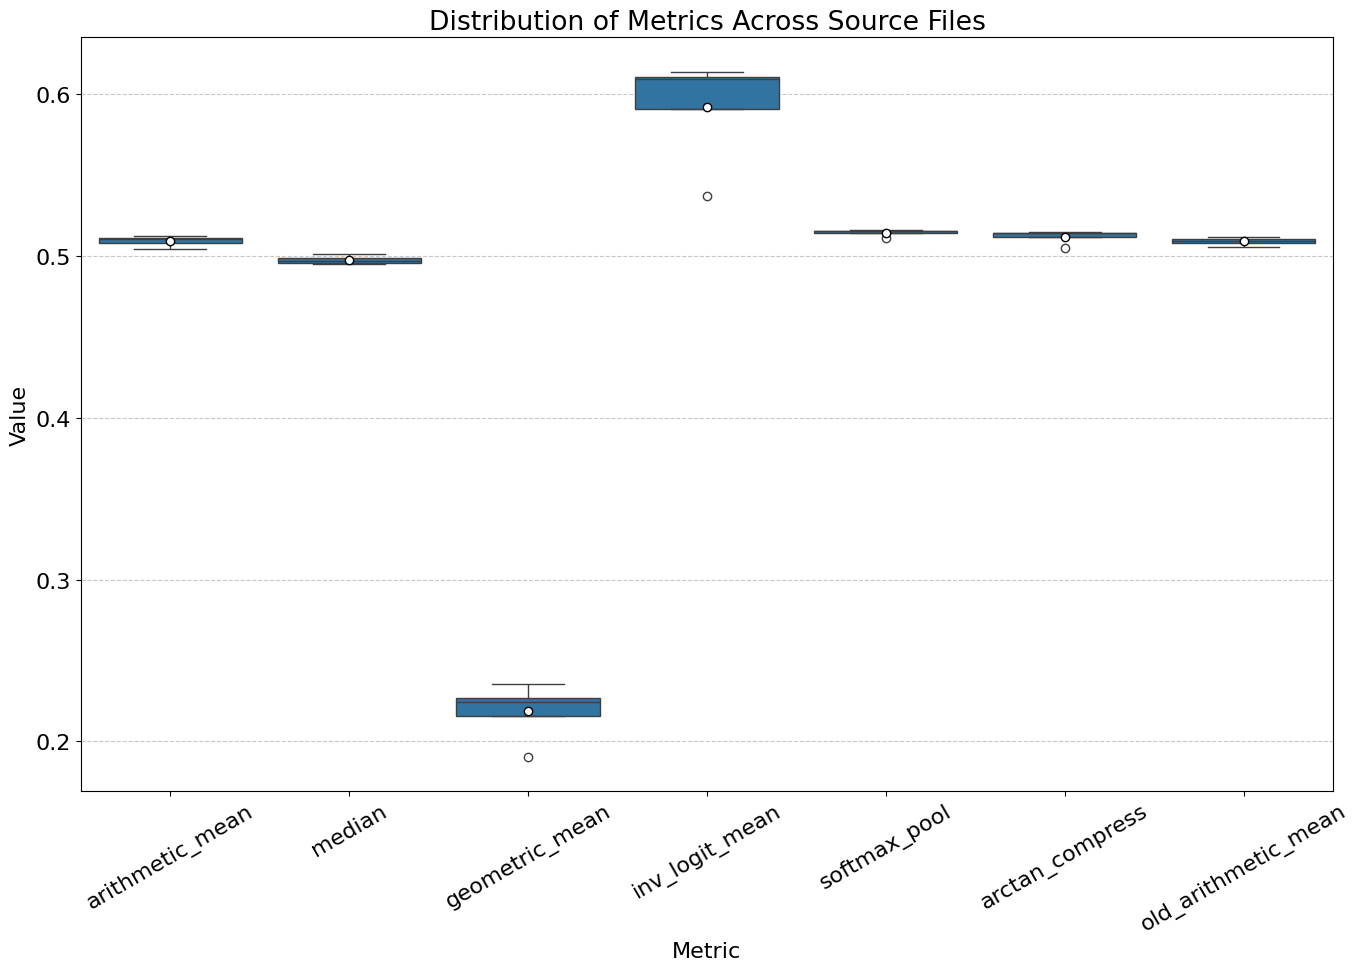

In [164]:
import matplotlib.pyplot as plt
import seaborn as sns

# Make sure your DataFrame is named correctly, e.g.:
df_summary = summary_by_source  # or whatever variable you used

plt.figure(figsize=(14, 10))
sns.boxplot(
    data=df_summary,
    x="level_1",
    y="score_adj",
    showmeans=True,
    meanprops={"marker": "o", "markerfacecolor": "white", "markeredgecolor": "black"},
)

plt.title("Distribution of Metrics Across Source Files")
plt.xlabel("Metric")
plt.ylabel("Value")
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.xticks(rotation=30)
plt.tight_layout()
plt.show()

In [165]:
# Directory path
csv_dir = (
    "/scratch/project/tcr_ml/gnn_release/icantcrscoring/model_2025_sc_curated/PICA"
)

# Get all CSV files in the directory
csv_files = [
    f
    for f in glob.glob(os.path.join(csv_dir, "*.csv"))
    if os.path.basename(f) != "summary.csv"
]
# Load all CSV files into a list of DataFrames
dataframes = []
for file in csv_files:
    df = pd.read_csv(file)
    # Optional: add a column to track which file the data came from
    df["source_file"] = os.path.basename(file)
    dataframes.append(df)

# If you want to combine all DataFrames into one
combined_control_df = pd.concat(dataframes, ignore_index=True)

combined_control_df

,AA_seq,CloneFreq,prob,high,transformed_score,source_file
0,CASTPGDEQYF,0.003607,0.575344,False,0.002075,20240918_WGS_20240924_sc_PICA0008-PICA0032_Poo...
1,CASSLGSGQYF,0.001945,0.588268,False,0.001144,20240918_WGS_20240924_sc_PICA0008-PICA0032_Poo...
2,CASSLGSGQYF,0.001945,0.588268,False,0.001144,20240918_WGS_20240924_sc_PICA0008-PICA0032_Poo...
3,CASSLGSGQYF,0.001945,0.588268,False,0.001144,20240918_WGS_20240924_sc_PICA0008-PICA0032_Poo...
4,CASSLGSGQYF,0.001945,0.588268,False,0.001144,20240918_WGS_20240924_sc_PICA0008-PICA0032_Poo...
...,...,...,...,...,...,...
149200,CATSDSTRGDSYNEQFF,0.000038,0.144616,False,0.000005,20241106_WGS_20241106_sc_PICA0033-PICA0069_Poo...
149201,CSAGGDRSNQPQHF,0.000038,0.086664,False,0.000003,20241106_WGS_20241106_sc_PICA0033-PICA0069_Poo...
149202,CSAREPGSSPLHF,0.000038,0.909164,True,0.000035,20241106_WGS_20241106_sc_PICA0033-PICA0069_Poo...
149203,CAISETSEVGYEQYF,0.000038,0.329552,False,0.000013,20241106_WGS_20241106_sc_PICA0033-PICA0069_Poo...


In [166]:
import numpy as np

combined_control_df["blend"] = combined_score_sample_blend(
    P=combined_control_df["prob"].values, F_raw=combined_control_df["CloneFreq"].values
)
S = combined_score_distribution_aware_simple(P=combined_control_df["blend"].values)
# Add results back to the DataFrame
combined_control_df["score_adj"] = S
# combined_control_df["CloneFreq_percentile"] = R
combined_control_df

,AA_seq,CloneFreq,prob,high,transformed_score,source_file,blend,score_adj
0,CASTPGDEQYF,0.003607,0.575344,False,0.002075,20240918_WGS_20240924_sc_PICA0008-PICA0032_Poo...,0.575344,0.572229
1,CASSLGSGQYF,0.001945,0.588268,False,0.001144,20240918_WGS_20240924_sc_PICA0008-PICA0032_Poo...,0.588268,0.585153
2,CASSLGSGQYF,0.001945,0.588268,False,0.001144,20240918_WGS_20240924_sc_PICA0008-PICA0032_Poo...,0.588268,0.585153
3,CASSLGSGQYF,0.001945,0.588268,False,0.001144,20240918_WGS_20240924_sc_PICA0008-PICA0032_Poo...,0.588268,0.585153
4,CASSLGSGQYF,0.001945,0.588268,False,0.001144,20240918_WGS_20240924_sc_PICA0008-PICA0032_Poo...,0.588268,0.585153
...,...,...,...,...,...,...,...,...
149200,CATSDSTRGDSYNEQFF,0.000038,0.144616,False,0.000005,20241106_WGS_20241106_sc_PICA0033-PICA0069_Poo...,0.144616,0.141500
149201,CSAGGDRSNQPQHF,0.000038,0.086664,False,0.000003,20241106_WGS_20241106_sc_PICA0033-PICA0069_Poo...,0.086664,0.083549
149202,CSAREPGSSPLHF,0.000038,0.909164,True,0.000035,20241106_WGS_20241106_sc_PICA0033-PICA0069_Poo...,0.909164,0.906048
149203,CAISETSEVGYEQYF,0.000038,0.329552,False,0.000013,20241106_WGS_20241106_sc_PICA0033-PICA0069_Poo...,0.329552,0.326436


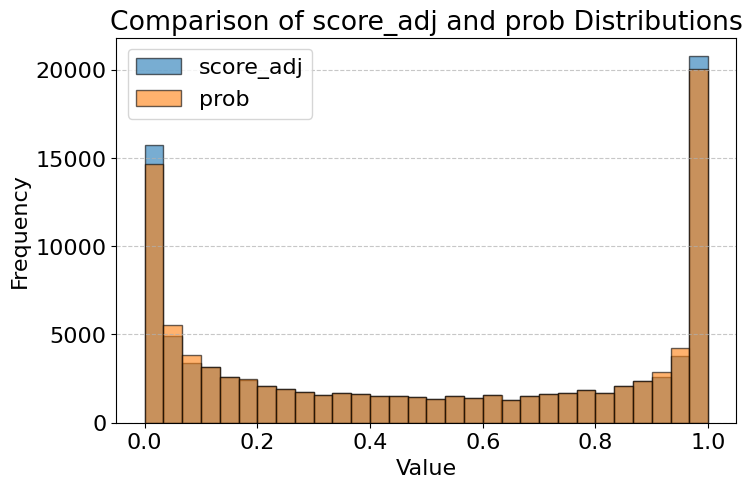

In [167]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 5))

# Plot histograms for both columns
plt.hist(
    combined_df["score_adj"], bins=30, alpha=0.6, label="score_adj", edgecolor="black"
)
plt.hist(combined_df["prob"], bins=30, alpha=0.6, label="prob", edgecolor="black")

# Labels and title
plt.title("Comparison of score_adj and prob Distributions")
plt.xlabel("Value")
plt.ylabel("Frequency")
plt.legend()
plt.grid(axis="y", linestyle="--", alpha=0.7)

plt.show()

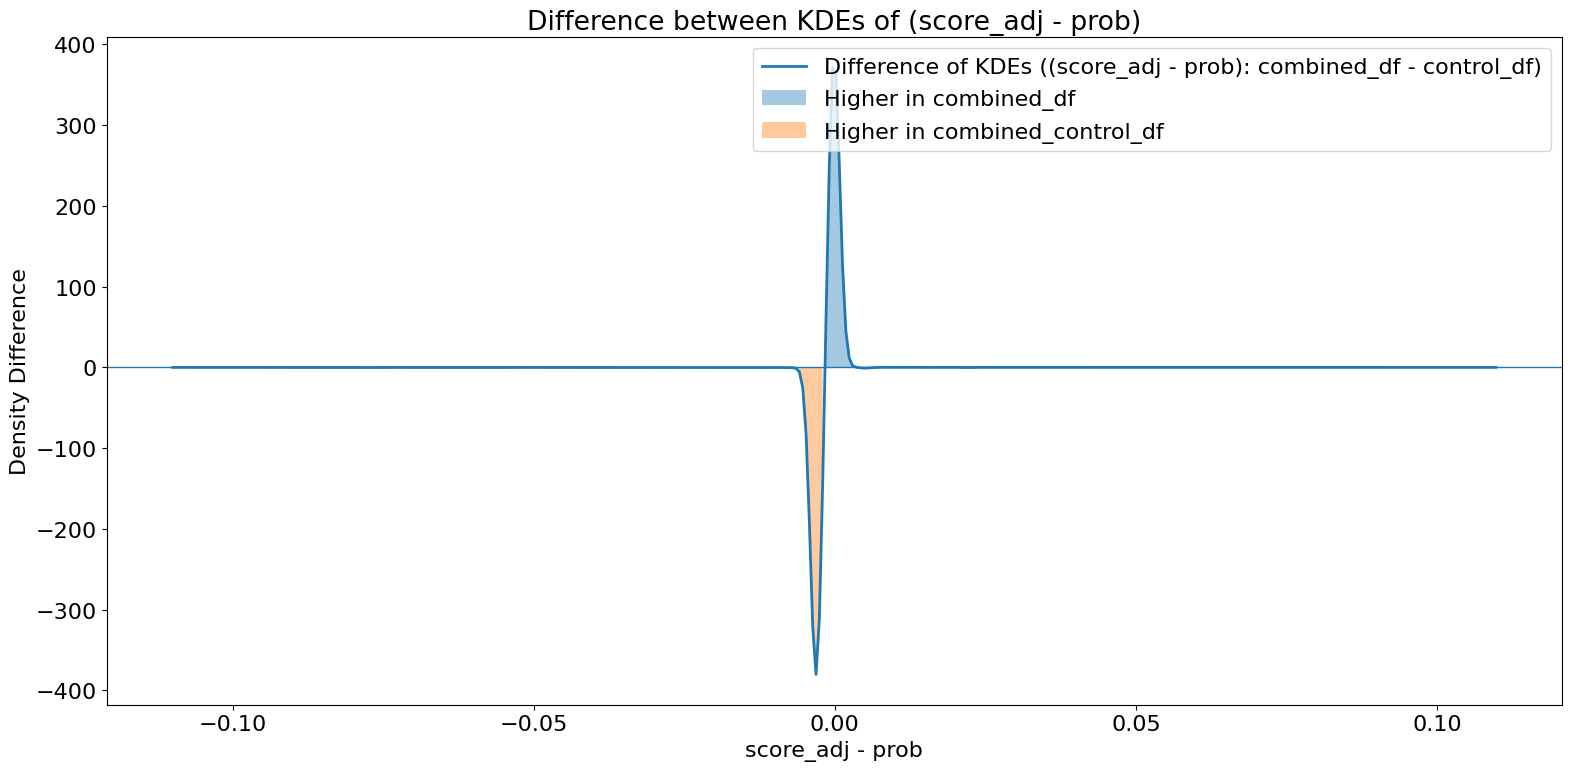

In [168]:
# Compute and plot the *difference* between the two KDE curves of (score_adj - prob)
# for combined_df and combined_control_df

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

try:
    from scipy.stats import gaussian_kde  # type: ignore

    _HAVE_SCIPY = True
except Exception:
    _HAVE_SCIPY = False


def _kde_gaussian_numpy(
    samples: np.ndarray, x_grid: np.ndarray, bandwidth: float | None = None
) -> np.ndarray:
    samples = samples[~np.isnan(samples)]
    n = samples.size
    if n == 0:
        return np.zeros_like(x_grid)
    std = samples.std(ddof=1) if n > 1 else 1e-6
    if bandwidth is None or bandwidth <= 0:
        bandwidth = 1.06 * std * n ** (-1 / 5)
        if bandwidth <= 1e-12:
            bandwidth = 1e-3
    diffs = (x_grid[:, None] - samples[None, :]) / bandwidth
    kernel_vals = np.exp(-0.5 * diffs**2) / np.sqrt(2 * np.pi)
    density = kernel_vals.sum(axis=1) / (n * bandwidth)
    return density


def kde_1d(
    samples: np.ndarray, x_grid: np.ndarray, bw_adjust: float = 1.0
) -> np.ndarray:
    samples = samples[~np.isnan(samples)]
    if samples.size == 0:
        return np.zeros_like(x_grid)
    if _HAVE_SCIPY:
        kde = gaussian_kde(samples)
        default_factor = kde.covariance_factor()
        kde.set_bandwidth(bw_method=default_factor / bw_adjust)
        return kde.evaluate(x_grid)
    else:
        return _kde_gaussian_numpy(samples, x_grid)


def plot_difference_between_diffs(
    df1: pd.DataFrame,
    df2: pd.DataFrame,
    prob_col: str = "prob",
    adj_col: str = "score_adj",
    bw_adjust: float = 1.0,
    n_points: int = 400,
):
    d1 = (df1[adj_col] - df1[prob_col]).to_numpy(dtype=float)
    d2 = (df2[adj_col] - df2[prob_col]).to_numpy(dtype=float)

    lo = np.nanmin([np.nanmin(d1), np.nanmin(d2)])
    hi = np.nanmax([np.nanmax(d1), np.nanmax(d2)])
    pad = 0.05 * (hi - lo if np.isfinite(hi - lo) and (hi - lo) > 0 else 1.0)
    x_common = np.linspace(lo - pad, hi + pad, n_points)

    y1 = kde_1d(d1, x_common, bw_adjust=bw_adjust)
    y2 = kde_1d(d2, x_common, bw_adjust=bw_adjust)
    y_diff = y1 - y2

    plt.figure(figsize=(16, 8))
    plt.plot(
        x_common,
        y_diff,
        linewidth=2,
        label="Difference of KDEs ((score_adj - prob): combined_df - control_df)",
    )
    plt.fill_between(
        x_common,
        0,
        y_diff,
        where=(y_diff > 0),
        alpha=0.4,
        label="Higher in combined_df",
    )
    plt.fill_between(
        x_common,
        0,
        y_diff,
        where=(y_diff < 0),
        alpha=0.4,
        label="Higher in combined_control_df",
    )
    plt.axhline(0, linewidth=1)
    plt.title("Difference between KDEs of (score_adj - prob)")
    plt.xlabel("score_adj - prob")
    plt.ylabel("Density Difference")
    plt.legend()
    plt.tight_layout()
    plt.show()


# Use user data if available, else demo
_use_demo = False
if "combined_df" in globals() and "combined_control_df" in globals():
    _df1 = globals()["combined_df"]
    _df2 = globals()["combined_control_df"]
    if all(
        isinstance(df, pd.DataFrame) and {"prob", "score_adj"}.issubset(df.columns)
        for df in [_df1, _df2]
    ):
        plot_difference_between_diffs(
            _df1, _df2, prob_col="prob", adj_col="score_adj", bw_adjust=1.0
        )
    else:
        _use_demo = True

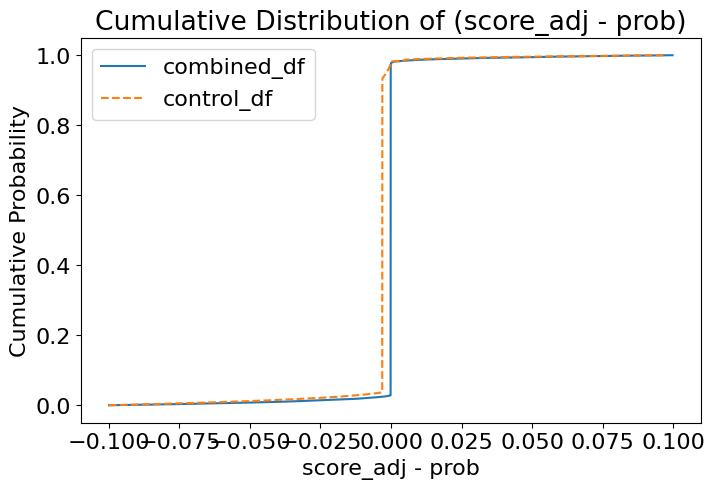

In [169]:
import matplotlib.pyplot as plt
import numpy as np

diff_combined = (
    (combined_df["score_adj"] - combined_df["prob"]).sort_values().to_numpy()
)
diff_control = (
    (combined_control_df["score_adj"] - combined_control_df["prob"])
    .sort_values()
    .to_numpy()
)

plt.figure(figsize=(8, 5))
plt.plot(diff_combined, np.linspace(0, 1, len(diff_combined)), label="combined_df")
plt.plot(
    diff_control,
    np.linspace(0, 1, len(diff_control)),
    label="control_df",
    linestyle="--",
)
plt.title("Cumulative Distribution of (score_adj - prob)")
plt.xlabel("score_adj - prob")
plt.ylabel("Cumulative Probability")
plt.legend()
plt.show()

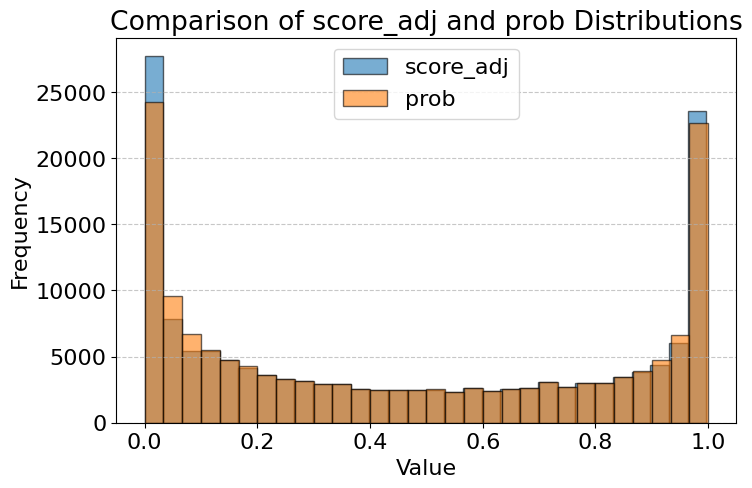

In [170]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 5))

# Plot histograms for both columns
plt.hist(
    combined_control_df["score_adj"],
    bins=30,
    alpha=0.6,
    label="score_adj",
    edgecolor="black",
)
plt.hist(
    combined_control_df["prob"], bins=30, alpha=0.6, label="prob", edgecolor="black"
)

# Labels and title
plt.title("Comparison of score_adj and prob Distributions")
plt.xlabel("Value")
plt.ylabel("Frequency")
plt.legend()
plt.grid(axis="y", linestyle="--", alpha=0.7)

plt.show()

In [171]:
import numpy as np
import pandas as pd


# summarize for score_adj
summary_by_source = (
    combined_control_df.groupby("source_file")["score_adj"]
    .apply(summarize_probs)
    .reset_index()
)

# compute arithmetic mean of untransformed 'prob'
old_means = (
    combined_control_df.groupby("source_file")["prob"]
    .mean()
    .rename("score_adj")  # same column name for consistency
    .reset_index()
)
old_means["level_1"] = "old_arithmetic_mean"

# append as new rows
summary_by_source = pd.concat([summary_by_source, old_means], ignore_index=True)

# optional: reorder columns
summary_by_source = summary_by_source[["source_file", "level_1", "score_adj"]]

summary_by_source

,source_file,level_1,score_adj
0,20240530_WGS_20240530_sc_PICA0001-PICA0007_PMI...,arithmetic_mean,0.459877
1,20240530_WGS_20240530_sc_PICA0001-PICA0007_PMI...,median,0.397590
2,20240530_WGS_20240530_sc_PICA0001-PICA0007_PMI...,geometric_mean,0.182366
3,20240530_WGS_20240530_sc_PICA0001-PICA0007_PMI...,inv_logit_mean,0.408805
4,20240530_WGS_20240530_sc_PICA0001-PICA0007_PMI...,softmax_pool,0.499807
...,...,...,...
163,20250114_WGS_20241218_sc_PICA0071-PICA0097_Poo...,old_arithmetic_mean,0.459785
164,20250114_WGS_20241218_sc_PICA0071-PICA0097_Poo...,old_arithmetic_mean,0.469870
165,20250114_WGS_20241218_sc_PICA0071-PICA0097_Poo...,old_arithmetic_mean,0.462667
166,20250114_WGS_20241218_sc_PICA0071-PICA0097_Poo...,old_arithmetic_mean,0.467074


In [172]:
count_below = (combined_control_df["score_adj"] < 0.01).sum()
prob_count = (combined_control_df["prob"] < 0.01).sum()

# Percentage increase from prob_count to count_below
if prob_count != 0:
    pct_increase = ((count_below - prob_count) / prob_count) * 100
else:
    pct_increase = float("inf")  # Avoid divide-by-zero error

print(f"Number of rows where score_adj < 0.01: {count_below}")
print(f"Number of rows where prob < 0.01: {prob_count}")
print(f"Percentage increase: {pct_increase:.2f}%")

Number of rows where score_adj < 0.01: 19262
Number of rows where prob < 0.01: 13000
Percentage increase: 48.17%


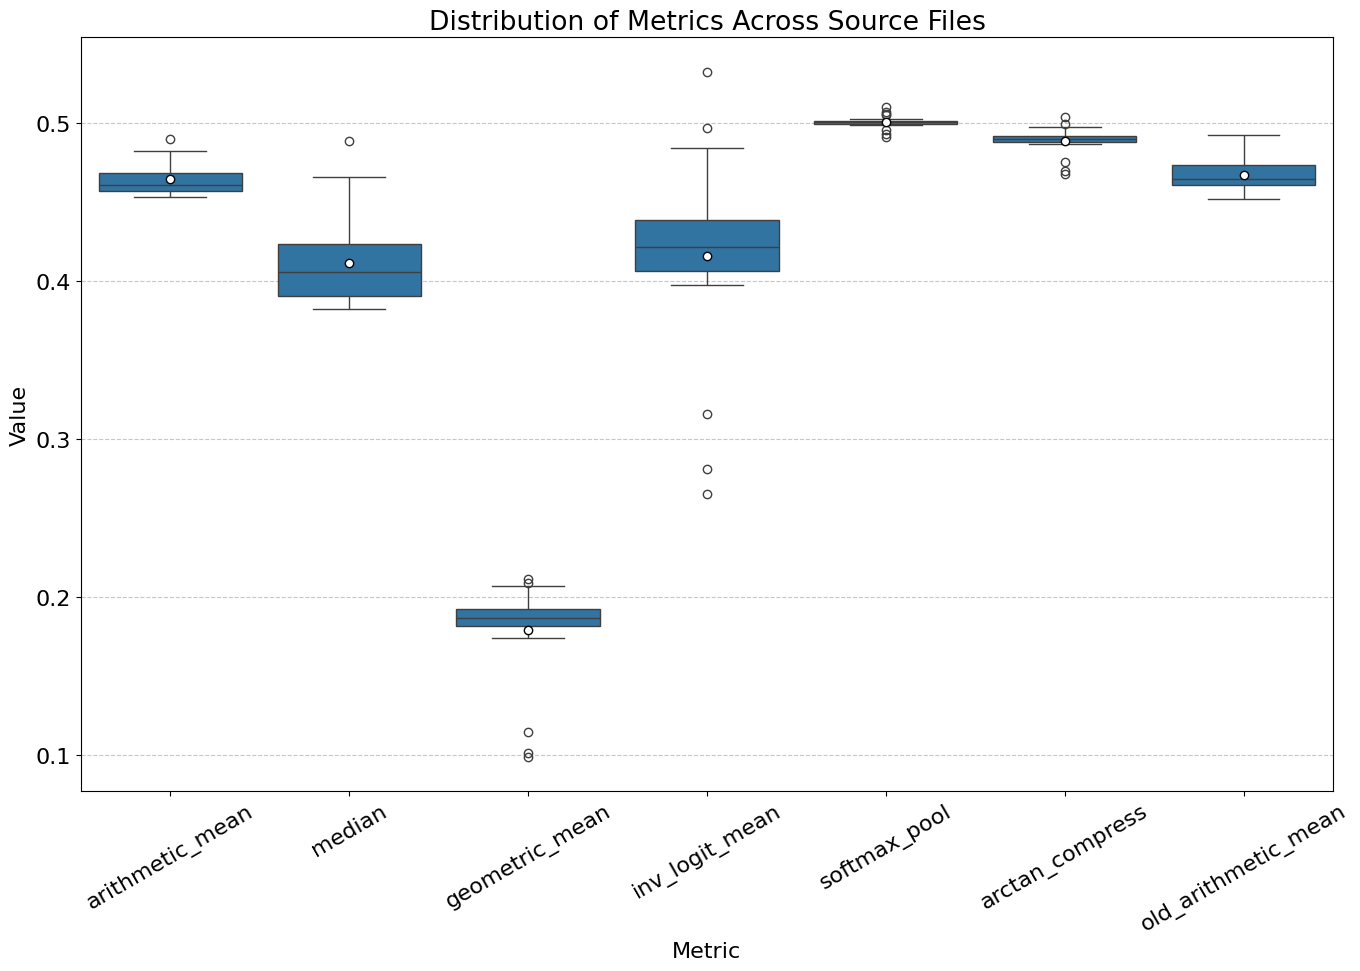

In [173]:
import matplotlib.pyplot as plt
import seaborn as sns

# Make sure your DataFrame is named correctly, e.g.:
df_summary_control = summary_by_source  # or whatever variable you used

plt.figure(figsize=(14, 10))
sns.boxplot(
    data=df_summary_control,
    x="level_1",
    y="score_adj",
    showmeans=True,
    meanprops={"marker": "o", "markerfacecolor": "white", "markeredgecolor": "black"},
)

plt.title("Distribution of Metrics Across Source Files")
plt.xlabel("Metric")
plt.ylabel("Value")
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.xticks(rotation=30)
plt.tight_layout()
plt.show()

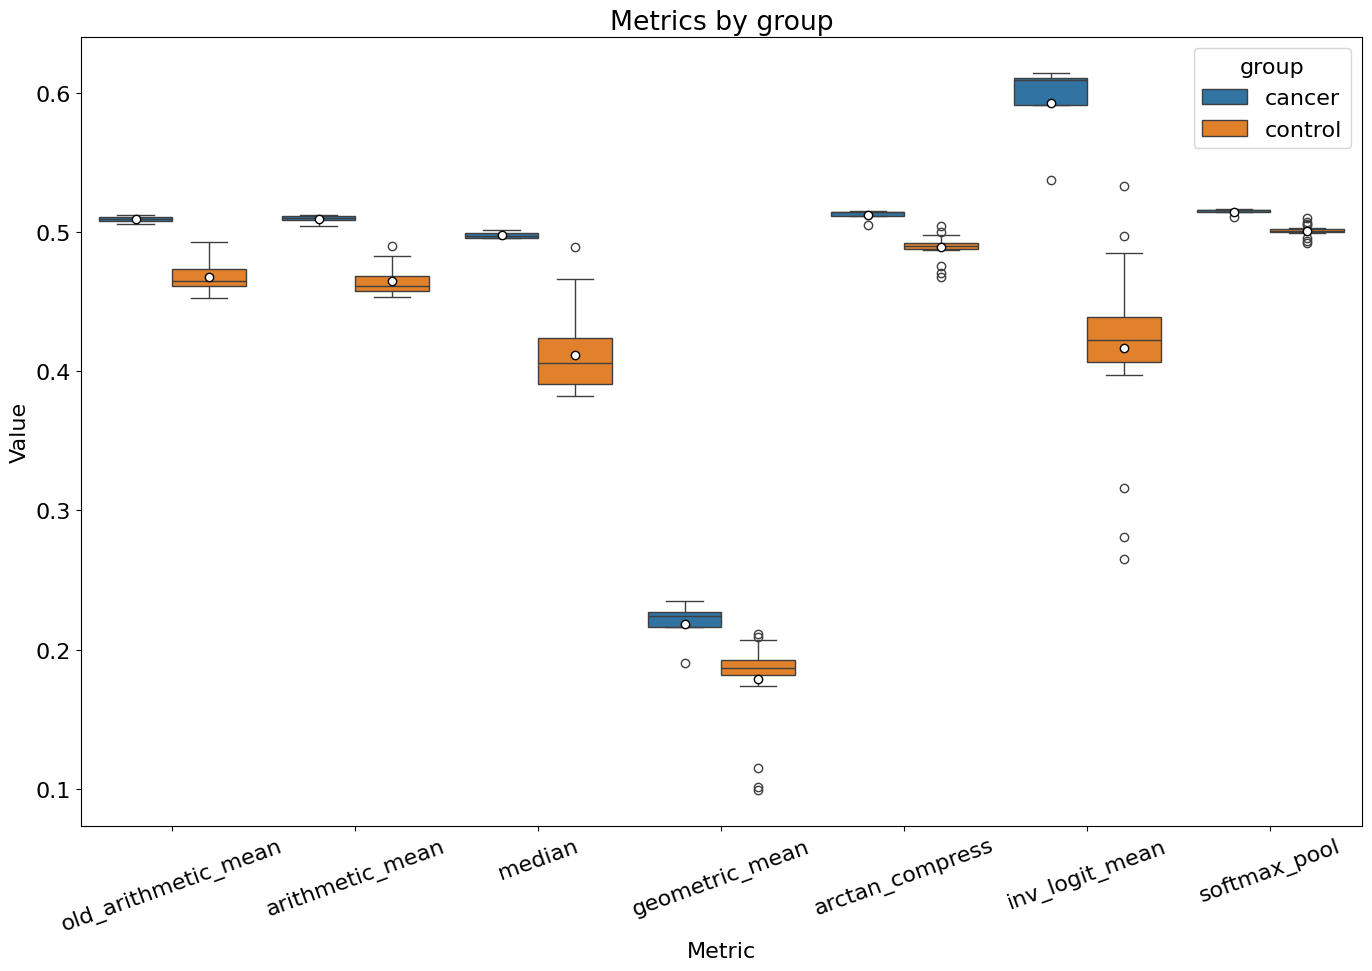

In [174]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Tag and combine
dfc = df_summary.copy()
dfc["group"] = "cancer"
dfk = df_summary_control.copy()
dfk["group"] = "control"
df_long = pd.concat([dfc, dfk], ignore_index=True)

# Pick metric order if you want consistent x positions
metrics = [
    "old_arithmetic_mean",
    "arithmetic_mean",
    "median",
    "geometric_mean",
    "arctan_compress",
    "inv_logit_mean",
    "softmax_pool",
]
metrics = [m for m in metrics if m in df_long["level_1"].unique()]

plt.figure(figsize=(14, 10))
sns.boxplot(
    data=df_long,
    x="level_1",
    y="score_adj",
    hue="group",
    order=metrics,
    showmeans=True,
    meanprops={"marker": "o", "markerfacecolor": "white", "markeredgecolor": "black"},
)
plt.title("Metrics by group")
plt.xlabel("Metric")
plt.ylabel("Value")
plt.xticks(rotation=20)
plt.tight_layout()
plt.show()

/scratch/temp/17760975/ipykernel_2229828/44752821.py:35: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  auc = np.trapz(tpr, fpr)


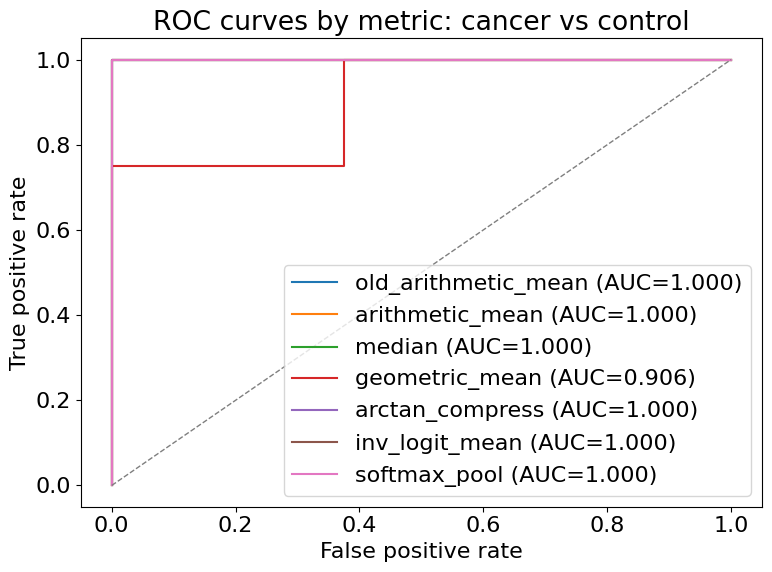

             metric     auc
old_arithmetic_mean 1.00000
    arithmetic_mean 1.00000
             median 1.00000
    arctan_compress 1.00000
     inv_logit_mean 1.00000
       softmax_pool 1.00000
     geometric_mean 0.90625


In [175]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Expecting:
# df_summary, df_summary_control with columns: ["source_file", "level_1", "score_adj"]


def roc_curve_manual(y_true: np.ndarray, y_score: np.ndarray):
    y_true = y_true.astype(int)
    order = np.argsort(-y_score)  # sort by score desc
    y_true_sorted = y_true[order]
    y_score_sorted = y_score[order]

    P = y_true_sorted.sum()
    N = len(y_true_sorted) - P
    if P == 0 or N == 0:
        # cannot compute ROC if only one class present
        return np.array([0.0, 1.0]), np.array([0.0, 1.0]), np.nan

    tps = np.cumsum(y_true_sorted)
    fps = np.cumsum(1 - y_true_sorted)

    # take points only where score changes, plus last point
    diffs = np.diff(y_score_sorted)
    idx = np.where(diffs != 0)[0]
    idx = np.r_[idx, len(y_true_sorted) - 1]

    tpr = tps[idx] / P
    fpr = fps[idx] / N

    # add origin
    tpr = np.r_[0.0, tpr]
    fpr = np.r_[0.0, fpr]

    auc = np.trapz(tpr, fpr)
    return fpr, tpr, auc


# Tag group and combine
dfc = df_summary.copy()
dfc["group"] = "cancer"
dfk = df_summary_control.copy()
dfk["group"] = "control"
df_long = pd.concat([dfc, dfk], ignore_index=True)

# Coerce numeric
df_long["score_adj"] = pd.to_numeric(df_long["score_adj"], errors="coerce")

# Which metrics to compare
metrics = [
    "old_arithmetic_mean",
    "arithmetic_mean",
    "median",
    "geometric_mean",
    "arctan_compress",
    "inv_logit_mean",
    "softmax_pool",
]
metrics = [m for m in metrics if m in df_long["level_1"].unique()]

# Plot ROC curves
plt.figure(figsize=(8, 6))
auc_rows = []

for m in metrics:
    sub = df_long[df_long["level_1"] == m].dropna(subset=["score_adj", "group"])
    if sub.empty:
        continue
    y_true = (sub["group"].values == "cancer").astype(int)
    y_score = sub["score_adj"].values.astype(float)

    fpr, tpr, auc = roc_curve_manual(y_true, y_score)
    auc_rows.append({"metric": m, "auc": auc})

    plt.plot(fpr, tpr, label=f"{m} (AUC={auc:.3f})")

# diagonal
plt.plot([0, 1], [0, 1], linestyle="--", linewidth=1)
plt.xlabel("False positive rate")
plt.ylabel("True positive rate")
plt.title("ROC curves by metric: cancer vs control")
plt.legend(loc="lower right")
plt.tight_layout()
plt.show()

# AUC table
auc_df = pd.DataFrame(auc_rows).sort_values("auc", ascending=False)
print(auc_df.to_string(index=False))